In [1]:
import numpy as np
import pandas as pd
import yfinance as yf 

import math
import matplotlib as plt
import matplotlib.pyplot as plt
import sklearn

from sklearn.linear_model import QuantileRegressor
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from scipy.stats import norm

from sklearn import ensemble

import tensorflow as tf
from tensorflow import keras

In [3]:
def quantile_score(q,y,f):
    if f>y:
        score = 2*(1-q)*(f-y)
    else:
        score = 2*q*(y-f) 
    return score       

In [4]:
df_dax = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "^GDAXI")

[*********************100%***********************]  1 of 1 completed


In [5]:
# Data Import 
dax_5days = pd.read_pickle("/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/DAX/Dataframes/dax_fivedays")
vix_5days= pd.read_pickle("/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/DAX/Dataframes/vix_fivedays")
df_returns= pd.read_pickle("/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/DAX/Dataframes/vix_fivedays")

In [49]:


df_dax["vix"] = df_dax["vix"].interpolate(method='linear', limit_direction='forward', axis=0)






,Open,High,Low,Close,Adj Close,Volume,1Day Return,2Day Return,3Day Return,4Day Return,5Day Return,vix
Date,,,,,,,,,,,,
1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0,4.057731,5.047698,5.885123,7.082493,3.192645,NaN
1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0,0.989967,1.827393,3.024763,-0.865086,-0.928903,NaN
1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0,0.837426,2.034796,-1.855053,-1.918870,-4.082157,NaN
1988-01-06,1006.010010,1006.010010,1006.010010,1006.010010,1006.010010,0,1.197370,-2.692479,-2.756296,-4.919583,-4.023806,NaN
1988-01-07,1014.469971,1014.469971,1014.469971,1014.469971,1014.469971,0,-3.889849,-3.953666,-6.116953,-5.221176,-7.504712,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-17,15948.900391,15962.700195,15894.769531,15933.719727,15933.719727,46576400,NaN,NaN,NaN,NaN,NaN,22.635000
2022-01-18,15839.150391,15843.580078,15669.349609,15772.559570,15772.559570,70557600,NaN,NaN,NaN,NaN,NaN,23.200001
2022-01-19,15639.450195,15898.049805,15629.860352,15809.719727,15809.719727,74923900,NaN,NaN,NaN,NaN,NaN,23.990000


In [8]:
# pandas version rather than Keras.
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)


In [9]:
optimizer = tf.optimizers.Adam(0.001)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [21]:
x_train = df_dax["vix"]["1990-01-02":"2021-07-01"]
x_test = df_dax["vix"]["2021-07-01":]

y_train = df_dax["1Day Return"]["1990-01-02":"2021-07-01"]
y_test = df_dax["1Day Return"]["2021-07-01":]

In [28]:
EPOCHS = 200
BATCH_SIZE = 32
UNITS = 512

In [16]:
def gb_quantilekeras_pred(x_train, train_labels, q):
    print(q)
    # Set input_dim for the number of features.
    if len(x_train.shape) == 1:
        input_dim = 1
    else:
        input_dim = x_train.shape[1]
    model = keras.Sequential([
      keras.layers.Dense(UNITS, activation=tf.nn.relu,
                         input_dim=input_dim),
      keras.layers.Dense(UNITS, activation=tf.nn.relu),
      keras.layers.Dense(1)
    ])
    
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
    model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=0, validation_split=0.2, callbacks=[early_stop])
    
    # Predict the quantile
    return model

In [17]:
N_ESTIMATORS = 1000
def gb_quantile(X_train, train_labels,X, q):
    gbf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=N_ESTIMATORS,
                                             max_depth=3,
                                             learning_rate=0.1, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return gbf, gbf.predict(X)

In [13]:
df_dax[]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0
1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0
1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0
1988-01-06,1006.010010,1006.010010,1006.010010,1006.010010,1006.010010,0
1988-01-07,1014.469971,1014.469971,1014.469971,1014.469971,1014.469971,0
...,...,...,...,...,...,...
2022-01-27,15229.980469,15582.450195,15197.530273,15524.269531,15524.269531,105993600
2022-01-28,15411.860352,15416.589844,15122.650391,15318.950195,15318.950195,91381200
2022-01-31,15506.790039,15566.379883,15338.190430,15471.200195,15471.200195,88305600


In [52]:
x_test = df_dax["vix"]["2021-11-10":]
x_test 



Date
2021-11-10    19.900000
2021-11-11    18.389999
2021-11-12    17.690001
2021-11-15    17.459999
2021-11-16    17.080000
2021-11-17    17.190001
2021-11-18    18.150000
2021-11-19    19.010000
2021-11-22    19.590000
2021-11-23    20.910000
2021-11-24    20.959999
2021-11-25    24.974999
2021-11-26    28.990000
2021-11-29    25.690001
2021-11-30    28.559999
2021-12-01    32.610001
2021-12-02    30.680000
2021-12-03    35.320000
2021-12-06    30.820000
2021-12-07    24.690001
2021-12-08    23.110001
2021-12-09    22.120001
2021-12-10    21.299999
2021-12-13    21.180000
2021-12-14    23.000000
2021-12-15    23.469999
2021-12-16    22.129999
2021-12-17    23.260000
2021-12-20    27.389999
2021-12-21    22.680000
2021-12-22    21.360001
2021-12-23    18.930000
2021-12-27    19.410000
2021-12-28    18.469999
2021-12-29    18.000000
2021-12-30    17.790001
2022-01-03    18.540001
2022-01-04    17.809999
2022-01-05    20.170000
2022-01-06    21.059999
2022-01-07    20.799999
2022-01-10 

In [47]:
#x_text_series 
from datetime import datetime, timedelta
    

values = []
df_dax_scope = df_dax["1990-01-02":"2021-07-01"]
for i, value in df_dax_scope.High.iteritems():
    print(i)
    val_list = [df_dax_scope.High[i - timedelta(days=1)],
                df_dax_scope.High[i - timedelta(days=2)],
                df_dax_scope.High[i - timedelta(days=3)],
                df_dax_scope.High[i - timedelta(days=4)],
                df_dax_scope.High[i - timedelta(days=5)],
        
    ]
    values.append(array()) = []
    d = i - timedelta(days=1)
    print(d)
    print(df_vix.High[i])
    print(value)
    break
    

1990-01-02 00:00:00
1990-01-01 00:00:00
17.239999771118164
1788.8900146484375


In [23]:

x_train = df_dax["vix"]["1990-01-02":"2021-07-01"]
x_train = np.array(x_train)


x_test = df_dax["vix"]["2022-01-19"].reshape(-1,1)
x_test = np.array(x_test)
x_test = x_test.reshape(-1, 1)

In [25]:
print(x_train)


[17.23999977 18.19000053 19.21999931 ... 16.30999947 17.30999947
 16.01000023]


In [53]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

In [57]:
today = "2022-01-21"

In [64]:
import pandas as pd 

y_train = pd.read_pickle("/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/DAX/Dataframes/ytrain")
x_train = pd.read_pickle("/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/DAX/Dataframes/xtrain")
y_test = pd.read_pickle("/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/DAX/Dataframes/ytest")
x_test = pd.read_pickle("/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/DAX/Dataframes/xtest")

In [65]:
x_train = x_train.interpolate(method='linear', limit_direction='forward', axis=0)
y_train = y_train.interpolate(method='linear', limit_direction='forward', axis=0)
x_test = x_test.interpolate(method='linear', limit_direction='forward', axis=0)


x_train = x_train.interpolate(method='linear', limit_direction='forward', axis=1)
y_train = y_train.interpolate(method='linear', limit_direction='forward', axis=1)
x_test = x_test.interpolate(method='linear', limit_direction='forward', axis=1)


In [96]:
x_test

array([[16.01000023, 15.53999996, 16.74000025, 17.94000053, 17.63999939],
       [21.29000092, 18.12999916, 17.52000046, 17.22999954, 17.51000023],
       [18.09000015, 18.70000076, 25.09000015, 22.96999931, 19.81999969],
       [18.45000076, 17.47999954, 19.38999939, 20.44000053, 19.62000084],
       [18.01000023, 19.71999931, 19.87000084, 20.44000053, 18.89999962],
       [17.84000015, 17.5       , 17.38999939, 17.04999924, 17.09000015],
       [16.42000008, 15.72000027, 17.70999908, 19.55999947, 21.63999939],
       [24.73999977, 23.89999962, 18.95000076, 17.51000023, 17.5       ],
       [19.27000046, 18.21999931, 16.79999924, 17.06999969, 16.70999908],
       [16.97999954, 17.05999947, 18.98999977, 18.38999939, 19.63999939],
       [19.54000092, 21.12999916, 21.18000031, 20.46999931, 20.27000046],
       [19.76000023, 21.51000023, 28.79000092, 25.60000038, 23.39999962],
       [20.20999908, 20.40999985, 19.31999969, 24.81999969, 23.79000092],
       [24.70999908, 24.88999939, 24.5

In [62]:
x_test.isnull().values.any()

False

In [99]:
len(x_test)

30

In [68]:
QUANTILES = [0.025,0.25,0.5,0.75,0.975]
#x_train = df_dax["vix"]["1990-01-02":"2021-07-01"]
x_train = np.array(x_train)

#vix_sliding_window = np.lib.stride_tricks.sliding_window_view(x_train,5)
#x_train =vix_sliding_window

 

x_test = np.array(x_test)
x_test = x_test #.reshape(1,-1)
results_gb = []

for h in range(5):
    train_data = y_train.loc[:, h]
    model_1, pred1 = gb_quantile(x_train, np.array(y_train.loc[:, h]),x_test, QUANTILES[0])
    model_2, pred2 = gb_quantile(x_train, np.array(y_train.loc[:, h]),x_test, QUANTILES[1])
    model_3, pred3 = gb_quantile(x_train, np.array(y_train.loc[:, h]),x_test, QUANTILES[2])
    model_4, pred4 = gb_quantile(x_train, np.array(y_train.loc[:, h]),x_test, QUANTILES[3])
    model_5, pred5 = gb_quantile(x_train, np.array(y_train.loc[:, h]),x_test, QUANTILES[4])

    results_gb.append([pred1,pred2,pred3,pred4,pred5])
    


In [89]:
results_gb_df = pd.DataFrame(results_gb)

In [100]:
results_gb_df = pd.read_pickle("/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/Evaluation/Dax/VIX and 5 Days/30_obs")

In [104]:
2.6853809017215737
results_gb_df.iloc[4,4]

array([4.59652344, 4.48233555, 5.14829844, 5.01641089, 4.97171506,
       4.59652344, 4.87161587, 4.98692768, 4.48233555, 4.59652344,
       4.97171506, 5.22315506, 5.22315506, 5.4167298 , 5.14829844,
       3.80217566, 4.8916576 , 4.4447525 , 4.59652344, 4.48233555,
       5.14829844, 5.57805773, 5.55126302, 5.22315506, 5.14829844,
       4.48233555, 4.59652344, 5.14829844, 5.25404366, 6.15630128])

<AxesSubplot:>

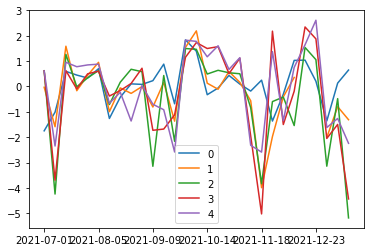

In [95]:
y_test.plot()

In [92]:
results_gb_df[0]

TypeError: no numeric data to plot

In [75]:
pred = model_1.predict(x_test)

In [84]:
len(results_gb[0][0])

30

In [ ]:
for h in range(5):
    y_train = df_dax[f"{h+1}Day Return"]["1990-01-02":"2021-07-01"]
    pred1 = gb_quantile(x_train.reshape(-1, 1), y_train,x_test, QUANTILES[0])
    pred2 = gb_quantile(x_train.reshape(-1, 1), y_train, x_test,QUANTILES[1])
    pred3 = gb_quantile(x_train.reshape(-1, 1), y_train, x_test,QUANTILES[2])
    pred4 = gb_quantile(x_train.reshape(-1, 1), y_train,x_test, QUANTILES[3])
    pred5 = gb_quantile(x_train.reshape(-1, 1), y_train,x_test, QUANTILES[4])

    results_gb.append([pred1,pred2,pred3,pred4,pred5])

In [73]:
results_gb


resluts = list(results_gb)

results = pd.DataFrame(index = range(5),columns = range(5))
for i in range(5):
    for j in range(5):
        results.iloc[i,j] = results_gb[i][j][0]
        

results 



results

,0,1,2,3,4
0,-2.036066,-0.408002,0.089699,0.633865,1.964794
1,-2.842279,-0.600356,0.260046,0.912527,2.285617
2,-2.729619,0.031748,0.518304,1.166268,3.999614
3,-3.841589,-0.311584,0.462029,1.435982,4.16165
4,-3.819978,-0.842407,0.402762,1.456286,4.596523


In [31]:
results.to_csv("/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/Predictions/Week_14/DAX",index=False,header=False)

In [169]:


model_1 = keras_pred(x_train, y_train, QUANTILES[0])
model_2 = keras_pred(x_train, y_train, QUANTILES[1])
model_3 = keras_pred(x_train, y_train, QUANTILES[2])
model_4 = keras_pred(x_train, y_train, QUANTILES[3])
model_5 = keras_pred(x_train, y_train, QUANTILES[4])

0.025
0.25
0.5
0.75
0.975


In [170]:
x_test = np.array(x_test)
x_test = x_test.reshape(-1, 1)
x_test 

r1 = model_1.predict(x_test)
r2 = model_2.predict(x_test)
r3 =model_3.predict(x_test)
r4 =model_4.predict(x_test)
r5 =model_5.predict(x_test)


In [181]:
r5

array([[1.8642938],
       [1.8071624],
       [1.95303  ],
       [2.0988977],
       [2.0624306],
       [2.5061114],
       [2.1219933],
       [2.0478442],
       [2.0125926],
       [2.0466285],
       [2.1171312],
       [2.1912806],
       [2.9680257],
       [2.710326 ],
       [2.3274238],
       [2.1608918],
       [2.0429816],
       [2.2751544],
       [2.4027886],
       [2.3031125],
       [2.1074066],
       [2.315268 ],
       [2.3335016],
       [2.4027886],
       [2.215592 ],
       [2.0867422],
       [2.045413 ],
       [2.0320415],
       [1.9907123],
       [1.9955748],
       [1.914132 ],
       [1.8290426],
       [2.0709395],
       [2.295819 ],
       [2.5486562],
       [2.9254808],
       [2.8233736],
       [2.22167  ],
       [2.0466285],
       [2.045413 ],
       [2.2605677],
       [2.1329334],
       [1.9603232],
       [1.9931436],
       [1.9493831],
       [1.9822035],
       [1.991928 ],
       [2.072763 ],
       [2.153598 ],
       [2.3055434],


In [ ]:
preds.loc[preds.method == 'QuantReg', 'pred'] = np.concatenate(
    [quantreg.fit(q=q).predict(X_test) for q in QUANTILES])

In [176]:
#quantile Regression 
#Change
tau = [2.5, 25, 50, 75, 97.5]

predictions_h = {}
for h in range(1,6):
    y_true_mean = 0 #by definition of daily returns 
    X =  abs(A[0].take(len(A[0])-1)).reshape(-1, 1)
    X_train = A[0][-(1000+h):-h].reshape(-1, 1)  # last 1000 daily returns
    y_train = A[h-1][-1000:] # followed h- step return


    quantiles = [i/100 for i in tau]
    predictions = {}
    out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0).fit(X_train, y_train)
        y_pred = qr.predict(X)
        predictions[quantile] = y_pred
        print(y_pred)
        #if quantile == min(quantiles):
        #    out_bounds_predictions = np.logical_or(
        #        out_bounds_predictions, y_pred >= y_train
         #   )
        #elif quantile == max(quantiles):
        #    out_bounds_predictions = np.logical_or(
        #        out_bounds_predictions, y_pred <= y_train
         #   )
    predictions_h[h] = predictions       

[-2.64894504]
[-0.47990873]
[0.07766716]
[0.6560946]
[2.29215149]
[-4.00491526]
[-0.76488063]
[0.16404084]
[0.90931944]
[3.13176057]
[-4.79087501]
[-0.83234025]
[0.17252311]
[1.21861506]
[3.96296334]
[-5.15382911]
[-0.96626705]
[0.23455031]
[1.3951978]
[4.87591302]
[-5.91218418]
[-1.07122018]
[0.36803665]
[1.47806466]
[5.42712002]


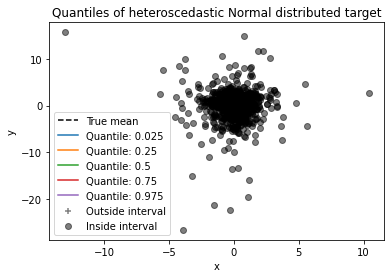

In [13]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    X_train[out_bounds_predictions],
    y_train[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    X_train[~out_bounds_predictions],
    y_train[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

In [31]:

filename = "/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/Predictions/Week_11/DAX_help"
pred_results.to_csv(filename, header=False, index = False)


filename2 = "/Users/finnbrunnenkant/Desktop/Master KIT/Semester 4/Probalistic TS/Predictions/Week_11/DAX"

import csv
import string

input_file = open(filename, 'r')
output_file = open(filename2, 'w')
data = csv.reader(input_file)
writer = csv.writer(output_file)
special1 = ']'
special2 = '['

for line in data:
    line = [value.replace(special1, '') for value in line]
    line = [value.replace(special2, '') for value in line]
    writer.writerow(line)

input_file.close()
output_file.close() 



NameError: name 'pred_results' is not defined